In [1]:
import copy, getpass, joblib, os, pickle, queue, random, sys, time, tqdm
import numpy as np
import torch
from torchvision.transforms import *

sys.path.append('../..')
from DL.utils import *
from DL.networks import *
from DL.losses import *
from DL.Engine import Engine
from DL.sqlite_data_loader import SQLDataLoader
from Database.DB_models import *
from sampling_methods.constants import get_AL_sampler
from sampling_methods.constants import get_wrapper_AL_mapping
get_wrapper_AL_mapping()

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
# matplotlib.use('GTK')
# import ipywidgets as wdg

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.neural_network import MLPClassifier


In [2]:
notebook_output_dirname = './test_sept_2019_output'
os.makedirs(notebook_output_dirname, exist_ok=True)

In [3]:
EMBEDDING_MODEL = '/home/lynx/pretrainedmodels/embedding_triplet_resnet50_1499/triplet_resnet50_1499.tar'
# EMBEDDING_MODEL = '/home/lynx/repos/CameraTraps/research/active_learning/experiments/notebooks/test_sept_2019_output/finetunedtriplet_resnet50_1000.tar'
CROP_DIR = '/datadrive/missouricameratraps/crops_detector/'
DB_LIMIT = 5000

In [4]:
# Load the pretrained embedding model
checkpoint = load_checkpoint(EMBEDDING_MODEL)
if checkpoint['loss_type'].lower() == 'center' or checkpoint['loss_type'].lower() == 'softmax':
    embedding_net = SoftmaxNet(checkpoint['arch'], checkpoint['feat_dim'], False)
else:
    embedding_net = NormalizedEmbeddingNet(checkpoint['arch'], checkpoint['feat_dim'], False)
model = torch.nn.DataParallel(embedding_net).cuda()
model.load_state_dict(checkpoint['state_dict'])
model.eval()

DataParallel(
  (module): NormalizedEmbeddingNet(
    (inner_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (re

In [6]:
DB_NAME = getpass.getpass('Enter database name:')
DB_USER = getpass.getpass('Enter username for database:')
DB_PASSWORD = getpass.getpass('Enter password for database user:')
RANDOM_SEED = 2345

Enter database name:········
Enter username for database:········
Enter password for database user:········


In [7]:
def moveRecords(dataset, srcKind, destKind, rList):
    for e in rList:
        dataset.set_indices[srcKind].remove(e)
        dataset.set_indices[destKind].append(e)

In [8]:
def finetune_embedding(model, loss_type, train_dataset, P, K, epochs):
    """
    Fine tune the embedding model.

    Arguments:
        model: Model to fine tune.
        loss_type: The loss function to minimize while fine tuning.
        train_dataset: Dataset object to use to train the embedding.
        P: Number of classes to sample from the dataset if using a balanced loader.
        K: Number of samples from each class to sample from the dataset if using a balanced loader.
        epochs: Number of epochs to train the embedding for.
    """
    train_dataset.image_mode()

    if loss_type.lower() == 'softmax':
        criterion = nn.CrossEntropyLoss().cuda()
        train_loader = train_dataset.getSingleLoader()
    elif loss_type.lower() == 'siamese':
        criterion = OnlineContrastiveLoss(1, HardNegativePairSelector())
        train_loader = train_dataset.getBalancedLoader(P = P, K = K)
    else:
        criterion = OnlineTripletLoss(1, RandomNegativeTripletSelector(1))
        train_loader = train_dataset.getBalancedLoader(P = P, K = K)

    params = model.parameters()
    optimizer = torch.optim.Adam(params, lr = 0.0001)#, weight_decay = 0.0005)
    e = Engine(model, criterion, optimizer, verbose = True, print_freq = 10)

    for epoch in range(epochs):
        e.train_one_epoch(train_loader, epoch, False)

# Baselines

## Strategies from Arash's Paper

Arash et al. propose that before beginning active learning, we should label 1000 random images from the target dataset and fine-tune the embedding on these first.

1. What is the benefit of fine-tuning the embedding to the target dataset before beginning active learning?
We compare 1) labeling 1000 randomly chosen images, fine-tuning the embedding, embedding these 1000 images, training a classifier, and then fine-tuning the classifier with 3000 more images chosen by uncertainty sampling, versus 2) labeling 1000 randomly chosen images, training a classifier, and then fine-tuning the classifier with 3000 more images chosen by uncertainty sampling.

In [9]:
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
target_db = PostgresqlDatabase(DB_NAME, user=DB_USER, password=DB_PASSWORD, host='localhost')
target_db.connect(reuse_if_open=True)
db_proxy.initialize(target_db)
dataset_query = Detection.select(Detection.image_id, Oracle.label, Detection.kind).join(Oracle).limit(DB_LIMIT)
dataset = SQLDataLoader(CROP_DIR, query=dataset_query, is_training=False, kind=DetectionKind.ModelDetection.value, num_workers=8, limit=DB_LIMIT)
dataset.updateEmbedding(model)
sample_ids = [s[0] for s in dataset.samples]
labels = [s[1] for s in dataset.samples]
imagepaths = dataset.getallpaths()


Reading database to get samples.
[0, 5000, 0, 0, 0]
Load dataset mean and std from database
Extracting embedding from the provided model ...
Batch 0
Embedding extraction is done.


In [10]:
random_ids = np.random.choice(dataset.current_set, 1000, replace=False).tolist()
moveRecords(dataset, DetectionKind.ModelDetection.value, DetectionKind.UserDetection.value, random_ids)

# # Finetune the embedding model
# dataset.set_kind(DetectionKind.UserDetection.value)
# dataset.train()
# finetune_embedding(model, checkpoint['loss_type'], dataset, 20, 4, 100)
# save_checkpoint({
#                 'arch': checkpoint['arch'],
#                 'state_dict': model.state_dict(),
#                 #'optimizer' : optimizer.state_dict(),
#                 'loss_type' : checkpoint['loss_type'],
#                 'feat_dim' : checkpoint['feat_dim'],
#                 'num_classes' : 21
#                 }, False, "%s/%s%s_%s_%04d.tar"%(notebook_output_dirname, 'finetuned', checkpoint['loss_type'], checkpoint['arch'], 1000))


In [11]:
# Embed these points and train a classifier
# dataset.set_kind(DetectionKind.ModelDetection.value)
# dataset.updateEmbedding(model)
dataset.embedding_mode()

kwargs = {}
kwargs["N"] = 100
kwargs["already_selected"] = dataset.set_indices[DetectionKind.UserDetection.value]
kwargs["model"] = MLPClassifier(alpha=0.0001)

# Train on samples that have been labeled so far
dataset.set_kind(DetectionKind.UserDetection.value)
X_train = dataset.em[dataset.current_set]
y_train = np.asarray(dataset.getlabels())


In [12]:
kwargs["model"].fit(X_train, y_train)
joblib.dump(kwargs["model"], "%s/%s_%04d.skmodel"%(notebook_output_dirname, 'original_embedding_classifier', 1000))

/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


['./test_sept_2019_output/original_embedding_classifier_1000.skmodel']

In [13]:
accuracies_finetuned_embedding = []
# Test on the samples that have not been labeled
dataset.set_kind(DetectionKind.ModelDetection.value)
dataset.embedding_mode()
X_test = dataset.em[dataset.current_set]
y_test = np.asarray(dataset.getlabels())
print("Accuracy", kwargs["model"].score(X_test, y_test))
accuracies_finetuned_embedding.append(kwargs["model"].score(X_test, y_test))

Accuracy 0.62575


In [14]:
dataset.embedding_mode()
dataset.train()
sampler = get_AL_sampler('confidence')(dataset.em, dataset.getalllabels(), 12)

In [15]:
numLabeled = len(dataset.set_indices[DetectionKind.UserDetection.value])
while numLabeled < 4000:
    print([len(x) for x in dataset.set_indices])
#     sys.stdout.flush()

    # Get indices of samples to get user to label
    if numLabeled == 0:
        indices = np.random.choice(dataset.current_set, kwargs["N"], replace=False).tolist()
    else:
        indices = sampler.select_batch(**kwargs)
    moveRecords(dataset, DetectionKind.ModelDetection.value, DetectionKind.UserDetection.value, indices)
    numLabeled = len(dataset.set_indices[DetectionKind.UserDetection.value])

    # Train on samples that have been labeled so far
    dataset.set_kind(DetectionKind.UserDetection.value)
    X_train = dataset.em[dataset.current_set]
    y_train = np.asarray(dataset.getlabels())

    kwargs["model"].fit(X_train, y_train)
    joblib.dump(kwargs["model"], "%s/%s_%04d.skmodel"%(notebook_output_dirname, 'original_embedding_classifier', numLabeled))

    # Test on the samples that have not been labeled
    dataset.set_kind(DetectionKind.ModelDetection.value)
    dataset.embedding_mode()
    X_test = dataset.em[dataset.current_set]
    y_test = np.asarray(dataset.getlabels())
    print("Accuracy", kwargs["model"].score(X_test, y_test))
    accuracies_finetuned_embedding.append(kwargs["model"].score(X_test, y_test))

    sys.stdout.flush()
    if numLabeled % 2000 == 1000:
        dataset.set_kind(DetectionKind.UserDetection.value)
        finetune_embedding(model, checkpoint['loss_type'], dataset, 10, 4, 100 if numLabeled == 1000 else 50)
        save_checkpoint({
        'arch': checkpoint['arch'],
        'state_dict': model.state_dict(),
        #'optimizer' : optimizer.state_dict(),
        'loss_type' : checkpoint['loss_type'],
        'feat_dim' : checkpoint['feat_dim'],
        'num_classes' : 21
        }, False, "%s/%s%s_%s_%04d.tar"%(notebook_output_dirname, 'finetuned', checkpoint['loss_type'], checkpoint['arch'], numLabeled))

        dataset.set_kind(DetectionKind.ModelDetection.value)
        dataset.updateEmbedding(model)
        dataset.embedding_mode()

[0, 4000, 0, 1000, 0]
Accuracy 0.6330769230769231


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0, 3900, 0, 1100, 0]
Accuracy 0.6521052631578947


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0, 3800, 0, 1200, 0]
Accuracy 0.6667567567567567


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0, 3700, 0, 1300, 0]
Accuracy 0.6766666666666666


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0, 3600, 0, 1400, 0]
Accuracy 0.6885714285714286


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0, 3500, 0, 1500, 0]
Accuracy 0.6932352941176471


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0, 3400, 0, 1600, 0]
Accuracy 0.7233333333333334


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0, 3300, 0, 1700, 0]
Accuracy 0.729375


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0, 3200, 0, 1800, 0]
Accuracy 0.7383870967741936


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0, 3100, 0, 1900, 0]
Accuracy 0.7613333333333333


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0, 3000, 0, 2000, 0]
Accuracy 0.7655172413793103


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0, 2900, 0, 2100, 0]
Accuracy 0.7882142857142858


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0, 2800, 0, 2200, 0]
Accuracy 0.7992592592592592


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0, 2700, 0, 2300, 0]
Accuracy 0.8026923076923077


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0, 2600, 0, 2400, 0]
Accuracy 0.8208


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0, 2500, 0, 2500, 0]
Accuracy 0.8325


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0, 2400, 0, 2600, 0]
Accuracy 0.8456521739130435


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0, 2300, 0, 2700, 0]
Accuracy 0.8622727272727273


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0, 2200, 0, 2800, 0]
Accuracy 0.8714285714285714


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0, 2100, 0, 2900, 0]
Accuracy 0.8835


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Epoch 0 Batch [0/300]	Time 0.239 0.239	Loss 1.1226 1.1226
Epoch 0 Batch [10/300]	Time 0.146 0.157	Loss 1.0058 1.1679
Epoch 0 Batch [20/300]	Time 0.146 0.152	Loss 0.9232 1.1625
Epoch 0 Batch [30/300]	Time 0.145 0.150	Loss 1.0796 1.1361
Epoch 0 Batch [40/300]	Time 0.146 0.149	Loss 0.9875 1.1176
Epoch 0 Batch [50/300]	Time 0.145 0.148	Loss 1.1124 1.1058
Epoch 0 Batch [60/300]	Time 0.146 0.148	Loss 1.2136 1.0926
Epoch 0 Batch [70/300]	Time 0.146 0.148	Loss 1.0965 1.0899
Epoch 0 Batch [80/300]	Time 0.145 0.147	Loss 1.0233 1.0897
Epoch 0 Batch [90/300]	Time 0.145 0.147	Loss 1.2194 1.0972
Epoch 0 Batch [100/300]	Time 0.146 0.147	Loss 1.2016 1.1000
Epoch 0 Batch [110/300]	Time 0.147 0.147	Loss 1.0659 1.1081
Epoch 0 Batch [120/300]	Time 0.145 0.147	Loss 1.1650 1.1093
Epoch 0 Batch [130/300]	Time 0.145 0.147	Loss 1.3353 1.1093
Epoch 0 Batch [140/300]	Time 0.147 0.147	Loss 1.2681 1.1086
Epoch 0 Batch [150/300]	Time 0.147 0.147	Loss 1.2896 1.1089
Epoch 0 Batch [160/300]	Time 0.145 0.147	Loss 1.027

Epoch 4 Batch [180/300]	Time 0.144 0.145	Loss 0.4628 1.0342
Epoch 4 Batch [190/300]	Time 0.145 0.145	Loss 1.3208 1.0344
Epoch 4 Batch [200/300]	Time 0.145 0.145	Loss 0.3877 1.0327
Epoch 4 Batch [210/300]	Time 0.144 0.145	Loss 1.1162 1.0237
Epoch 4 Batch [220/300]	Time 0.145 0.145	Loss 0.8010 1.0296
Epoch 4 Batch [230/300]	Time 0.145 0.145	Loss 1.3302 1.0264
Epoch 4 Batch [240/300]	Time 0.145 0.145	Loss 0.9688 1.0200
Epoch 4 Batch [250/300]	Time 0.144 0.145	Loss 0.0000 1.0138
Epoch 4 Batch [260/300]	Time 0.145 0.145	Loss 0.2938 1.0001
Epoch 4 Batch [270/300]	Time 0.145 0.145	Loss 0.5555 0.9989
Epoch 4 Batch [280/300]	Time 0.145 0.145	Loss 0.9163 1.0065
Epoch 4 Batch [290/300]	Time 0.144 0.145	Loss 1.1945 0.9973
Epoch 5 Batch [0/300]	Time 0.174 0.174	Loss 1.3808 1.3808
Epoch 5 Batch [10/300]	Time 0.145 0.158	Loss 0.7775 1.2285
Epoch 5 Batch [20/300]	Time 0.145 0.152	Loss 1.5328 1.1639
Epoch 5 Batch [30/300]	Time 0.145 0.149	Loss 1.1439 1.1591
Epoch 5 Batch [40/300]	Time 0.145 0.148	Loss 

Epoch 9 Batch [60/300]	Time 0.145 0.145	Loss 1.0493 0.5614
Epoch 9 Batch [70/300]	Time 0.144 0.145	Loss 0.0000 0.5629
Epoch 9 Batch [80/300]	Time 0.144 0.145	Loss 1.5825 0.5655
Epoch 9 Batch [90/300]	Time 0.145 0.145	Loss 0.7230 0.6061
Epoch 9 Batch [100/300]	Time 0.145 0.145	Loss 3.1355 0.6465
Epoch 9 Batch [110/300]	Time 0.144 0.145	Loss 0.8445 0.6171
Epoch 9 Batch [120/300]	Time 0.144 0.145	Loss 0.4441 0.6479
Epoch 9 Batch [130/300]	Time 0.145 0.145	Loss 0.9046 0.6333
Epoch 9 Batch [140/300]	Time 0.144 0.145	Loss 0.0000 0.6430
Epoch 9 Batch [150/300]	Time 0.144 0.145	Loss 0.0000 0.6359
Epoch 9 Batch [160/300]	Time 0.145 0.145	Loss 1.0523 0.6418
Epoch 9 Batch [170/300]	Time 0.144 0.145	Loss 0.0000 0.6387
Epoch 9 Batch [180/300]	Time 0.144 0.145	Loss 0.0000 0.6313
Epoch 9 Batch [190/300]	Time 0.148 0.145	Loss 0.8412 0.6451
Epoch 9 Batch [200/300]	Time 0.146 0.145	Loss 1.5095 0.6522
Epoch 9 Batch [210/300]	Time 0.144 0.145	Loss 0.0000 0.6542
Epoch 9 Batch [220/300]	Time 0.145 0.145	Los

Epoch 13 Batch [220/300]	Time 0.144 0.145	Loss 0.0000 0.2906
Epoch 13 Batch [230/300]	Time 0.145 0.145	Loss 0.9156 0.2919
Epoch 13 Batch [240/300]	Time 0.146 0.145	Loss 0.0000 0.2970
Epoch 13 Batch [250/300]	Time 0.144 0.145	Loss 0.0000 0.3019
Epoch 13 Batch [260/300]	Time 0.144 0.145	Loss 0.4763 0.3131
Epoch 13 Batch [270/300]	Time 0.144 0.145	Loss 1.2463 0.3204
Epoch 13 Batch [280/300]	Time 0.144 0.145	Loss 0.0000 0.3175
Epoch 13 Batch [290/300]	Time 0.143 0.145	Loss 1.6160 0.3252
Epoch 14 Batch [0/300]	Time 0.157 0.157	Loss 0.6480 0.6480
Epoch 14 Batch [10/300]	Time 0.144 0.149	Loss 0.0000 0.4294
Epoch 14 Batch [20/300]	Time 0.144 0.147	Loss 0.0000 0.4268
Epoch 14 Batch [30/300]	Time 0.144 0.146	Loss 0.0000 0.5034
Epoch 14 Batch [40/300]	Time 0.144 0.146	Loss 0.0000 0.5218
Epoch 14 Batch [50/300]	Time 0.147 0.146	Loss 0.2270 0.5643
Epoch 14 Batch [60/300]	Time 0.144 0.145	Loss 0.0000 0.6067
Epoch 14 Batch [70/300]	Time 0.145 0.145	Loss 0.2892 0.5405
Epoch 14 Batch [80/300]	Time 0.14

Epoch 18 Batch [80/300]	Time 0.145 0.145	Loss 0.6910 0.2944
Epoch 18 Batch [90/300]	Time 0.144 0.145	Loss 0.4432 0.3324
Epoch 18 Batch [100/300]	Time 0.146 0.145	Loss 1.8214 0.3336
Epoch 18 Batch [110/300]	Time 0.144 0.145	Loss 0.0000 0.3276
Epoch 18 Batch [120/300]	Time 0.144 0.145	Loss 0.0000 0.3109
Epoch 18 Batch [130/300]	Time 0.144 0.145	Loss 0.0000 0.2965
Epoch 18 Batch [140/300]	Time 0.144 0.145	Loss 0.0000 0.2885
Epoch 18 Batch [150/300]	Time 0.144 0.145	Loss 0.0000 0.2954
Epoch 18 Batch [160/300]	Time 0.144 0.145	Loss 0.0000 0.2872
Epoch 18 Batch [170/300]	Time 0.144 0.145	Loss 0.0000 0.2836
Epoch 18 Batch [180/300]	Time 0.145 0.145	Loss 1.0801 0.2792
Epoch 18 Batch [190/300]	Time 0.146 0.145	Loss 0.0000 0.2805
Epoch 18 Batch [200/300]	Time 0.144 0.145	Loss 0.0000 0.2693
Epoch 18 Batch [210/300]	Time 0.144 0.145	Loss 0.0000 0.2618
Epoch 18 Batch [220/300]	Time 0.145 0.145	Loss 0.6705 0.2877
Epoch 18 Batch [230/300]	Time 0.144 0.145	Loss 0.0000 0.2818
Epoch 18 Batch [240/300]	T

Epoch 22 Batch [240/300]	Time 0.144 0.145	Loss 0.0000 0.3187
Epoch 22 Batch [250/300]	Time 0.144 0.145	Loss 0.0000 0.3060
Epoch 22 Batch [260/300]	Time 0.145 0.145	Loss 0.0000 0.2993
Epoch 22 Batch [270/300]	Time 0.145 0.145	Loss 0.0000 0.2883
Epoch 22 Batch [280/300]	Time 0.144 0.145	Loss 0.1489 0.2881
Epoch 22 Batch [290/300]	Time 0.143 0.145	Loss 0.0000 0.2922
Epoch 23 Batch [0/300]	Time 0.155 0.155	Loss 0.0000 0.0000
Epoch 23 Batch [10/300]	Time 0.144 0.145	Loss 0.0000 0.0000
Epoch 23 Batch [20/300]	Time 0.146 0.145	Loss 0.0000 0.1829
Epoch 23 Batch [30/300]	Time 0.144 0.145	Loss 0.5616 0.3058
Epoch 23 Batch [40/300]	Time 0.144 0.145	Loss 0.0000 0.2685
Epoch 23 Batch [50/300]	Time 0.144 0.145	Loss 0.8678 0.2630
Epoch 23 Batch [60/300]	Time 0.145 0.145	Loss 0.0000 0.2199
Epoch 23 Batch [70/300]	Time 0.144 0.145	Loss 0.0000 0.2007
Epoch 23 Batch [80/300]	Time 0.144 0.145	Loss 0.0000 0.1885
Epoch 23 Batch [90/300]	Time 0.145 0.145	Loss 3.1773 0.2210
Epoch 23 Batch [100/300]	Time 0.144

Epoch 27 Batch [100/300]	Time 0.144 0.145	Loss 0.0000 0.1762
Epoch 27 Batch [110/300]	Time 0.145 0.145	Loss 0.0000 0.1701
Epoch 27 Batch [120/300]	Time 0.144 0.145	Loss 0.0000 0.1573
Epoch 27 Batch [130/300]	Time 0.145 0.145	Loss 0.6886 0.1595
Epoch 27 Batch [140/300]	Time 0.144 0.145	Loss 0.4763 0.1745
Epoch 27 Batch [150/300]	Time 0.144 0.145	Loss 0.0000 0.1957
Epoch 27 Batch [160/300]	Time 0.144 0.145	Loss 0.0000 0.1889
Epoch 27 Batch [170/300]	Time 0.144 0.145	Loss 0.0000 0.1814
Epoch 27 Batch [180/300]	Time 0.144 0.145	Loss 0.3603 0.1734
Epoch 27 Batch [190/300]	Time 0.145 0.145	Loss 0.0000 0.1672
Epoch 27 Batch [200/300]	Time 0.144 0.145	Loss 0.0000 0.1787
Epoch 27 Batch [210/300]	Time 0.145 0.145	Loss 0.0000 0.1704
Epoch 27 Batch [220/300]	Time 0.144 0.145	Loss 0.0000 0.1627
Epoch 27 Batch [230/300]	Time 0.144 0.145	Loss 0.0000 0.1660
Epoch 27 Batch [240/300]	Time 0.145 0.145	Loss 1.5123 0.1712
Epoch 27 Batch [250/300]	Time 0.144 0.145	Loss 1.3518 0.1697
Epoch 27 Batch [260/300]

Epoch 31 Batch [260/300]	Time 0.144 0.145	Loss 0.0000 0.1479
Epoch 31 Batch [270/300]	Time 0.145 0.145	Loss 0.0000 0.1458
Epoch 31 Batch [280/300]	Time 0.145 0.145	Loss 0.0000 0.1406
Epoch 31 Batch [290/300]	Time 0.143 0.145	Loss 0.0000 0.1403
Epoch 32 Batch [0/300]	Time 0.171 0.171	Loss 0.0000 0.0000
Epoch 32 Batch [10/300]	Time 0.145 0.152	Loss 0.0000 0.1268
Epoch 32 Batch [20/300]	Time 0.144 0.148	Loss 0.0000 0.1666
Epoch 32 Batch [30/300]	Time 0.145 0.147	Loss 1.9245 0.2759
Epoch 32 Batch [40/300]	Time 0.144 0.146	Loss 2.6385 0.2979
Epoch 32 Batch [50/300]	Time 0.144 0.146	Loss 0.0000 0.2395
Epoch 32 Batch [60/300]	Time 0.145 0.146	Loss 0.0000 0.2060
Epoch 32 Batch [70/300]	Time 0.145 0.146	Loss 0.0000 0.1891
Epoch 32 Batch [80/300]	Time 0.144 0.145	Loss 0.0000 0.1733
Epoch 32 Batch [90/300]	Time 0.144 0.145	Loss 0.0000 0.1584
Epoch 32 Batch [100/300]	Time 0.144 0.145	Loss 0.0000 0.1473
Epoch 32 Batch [110/300]	Time 0.144 0.145	Loss 0.0000 0.1503
Epoch 32 Batch [120/300]	Time 0.145

Epoch 36 Batch [120/300]	Time 0.145 0.146	Loss 0.0000 0.1633
Epoch 36 Batch [130/300]	Time 0.144 0.146	Loss 0.0000 0.1509
Epoch 36 Batch [140/300]	Time 0.144 0.146	Loss 0.0000 0.1445
Epoch 36 Batch [150/300]	Time 0.145 0.146	Loss 0.0000 0.1366
Epoch 36 Batch [160/300]	Time 0.144 0.145	Loss 0.0000 0.1331
Epoch 36 Batch [170/300]	Time 0.144 0.145	Loss 0.0000 0.1337
Epoch 36 Batch [180/300]	Time 0.144 0.145	Loss 0.0000 0.1276
Epoch 36 Batch [190/300]	Time 0.148 0.145	Loss 0.0000 0.1354
Epoch 36 Batch [200/300]	Time 0.144 0.145	Loss 0.0000 0.1440
Epoch 36 Batch [210/300]	Time 0.144 0.145	Loss 0.0000 0.1511
Epoch 36 Batch [220/300]	Time 0.144 0.145	Loss 0.0000 0.1490
Epoch 36 Batch [230/300]	Time 0.144 0.145	Loss 0.0000 0.1425
Epoch 36 Batch [240/300]	Time 0.144 0.145	Loss 0.0000 0.1450
Epoch 36 Batch [250/300]	Time 0.144 0.145	Loss 0.0000 0.1407
Epoch 36 Batch [260/300]	Time 0.144 0.145	Loss 0.0000 0.1464
Epoch 36 Batch [270/300]	Time 0.144 0.145	Loss 0.0000 0.1452
Epoch 36 Batch [280/300]

Epoch 40 Batch [280/300]	Time 0.145 0.145	Loss 0.0000 0.2783
Epoch 40 Batch [290/300]	Time 0.143 0.145	Loss 0.8333 0.2743
Epoch 41 Batch [0/300]	Time 0.153 0.153	Loss 0.0000 0.0000
Epoch 41 Batch [10/300]	Time 0.144 0.150	Loss 0.0000 0.1806
Epoch 41 Batch [20/300]	Time 0.145 0.147	Loss 0.0000 0.0946
Epoch 41 Batch [30/300]	Time 0.145 0.146	Loss 1.2581 0.1441
Epoch 41 Batch [40/300]	Time 0.144 0.146	Loss 0.0000 0.1273
Epoch 41 Batch [50/300]	Time 0.145 0.146	Loss 0.0000 0.1997
Epoch 41 Batch [60/300]	Time 0.144 0.146	Loss 0.0000 0.2118
Epoch 41 Batch [70/300]	Time 0.144 0.146	Loss 0.0000 0.1938
Epoch 41 Batch [80/300]	Time 0.144 0.146	Loss 1.6165 0.2025
Epoch 41 Batch [90/300]	Time 0.144 0.146	Loss 0.7842 0.2009
Epoch 41 Batch [100/300]	Time 0.144 0.146	Loss 0.0000 0.1810
Epoch 41 Batch [110/300]	Time 0.145 0.145	Loss 0.0000 0.1647
Epoch 41 Batch [120/300]	Time 0.144 0.146	Loss 0.0000 0.1607
Epoch 41 Batch [130/300]	Time 0.144 0.145	Loss 0.0000 0.1556
Epoch 41 Batch [140/300]	Time 0.144

Epoch 45 Batch [140/300]	Time 0.145 0.145	Loss 2.4387 0.3040
Epoch 45 Batch [150/300]	Time 0.145 0.145	Loss 0.0000 0.2894
Epoch 45 Batch [160/300]	Time 0.151 0.145	Loss 0.0000 0.2781
Epoch 45 Batch [170/300]	Time 0.145 0.145	Loss 0.0000 0.2618
Epoch 45 Batch [180/300]	Time 0.146 0.145	Loss 0.0000 0.2473
Epoch 45 Batch [190/300]	Time 0.146 0.145	Loss 0.0000 0.2344
Epoch 45 Batch [200/300]	Time 0.145 0.145	Loss 0.0000 0.2227
Epoch 45 Batch [210/300]	Time 0.145 0.145	Loss 0.0000 0.2305
Epoch 45 Batch [220/300]	Time 0.145 0.145	Loss 0.4940 0.2569
Epoch 45 Batch [230/300]	Time 0.144 0.145	Loss 0.0000 0.2458
Epoch 45 Batch [240/300]	Time 0.144 0.145	Loss 0.0000 0.2356
Epoch 45 Batch [250/300]	Time 0.144 0.145	Loss 0.0000 0.2265
Epoch 45 Batch [260/300]	Time 0.144 0.145	Loss 0.0000 0.2178
Epoch 45 Batch [270/300]	Time 0.144 0.145	Loss 0.0000 0.2123
Epoch 45 Batch [280/300]	Time 0.145 0.145	Loss 0.0000 0.2048
Epoch 45 Batch [290/300]	Time 0.144 0.145	Loss 0.0000 0.1978
Epoch 46 Batch [0/300]	T

Extracting embedding from the provided model ...
Batch 0
Embedding extraction is done.
[0, 2000, 0, 3000, 0]
Accuracy 0.9278947368421052
[0, 1900, 0, 3100, 0]
Accuracy 0.9327777777777778


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0, 1800, 0, 3200, 0]
Accuracy 0.9370588235294117
[0, 1700, 0, 3300, 0]
Accuracy 0.92875


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0, 1600, 0, 3400, 0]
Accuracy 0.9306666666666666
[0, 1500, 0, 3500, 0]
Accuracy 0.9271428571428572
[0, 1400, 0, 3600, 0]
Accuracy 0.9307692307692308


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0, 1300, 0, 3700, 0]
Accuracy 0.9225
[0, 1200, 0, 3800, 0]
Accuracy 0.9181818181818182


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0, 1100, 0, 3900, 0]
Accuracy 0.922


In [18]:
# AL_trace = {}
# AL_trace['num_labeled'] = [i for i in range(1000,4100,100)]
# AL_trace['accuracies'] = accuracies_finetuned_embedding
# with open('%s/original_embedding_classifier_AL_trace.pkl'%(notebook_output_dirname), 'wb') as o:
#     pickle.dump(AL_trace, o)

In [20]:
finetuned_trace = pickle.load(open('%s/finetune_embedding_before_AL/finetuned_embedding_classifier_AL_trace.pkl'%(notebook_output_dirname), 'rb'))

/data/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:2: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  from ipykernel import kernelapp as app
/data/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/data/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


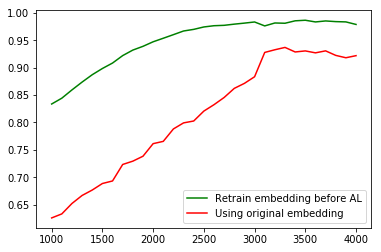

In [22]:
plt.plot(finetuned_trace['num_labeled'], finetuned_trace['accuracies'], 'g', label='Retrain embedding before AL')
plt.hold(True)
plt.plot(AL_trace['num_labeled'], AL_trace['accuracies'], 'r', label='Using original embedding')
plt.legend()

In [24]:
AL_trace['accuracies']

[0.62575,
 0.6330769230769231,
 0.6521052631578947,
 0.6667567567567567,
 0.6766666666666666,
 0.6885714285714286,
 0.6932352941176471,
 0.7233333333333334,
 0.729375,
 0.7383870967741936,
 0.7613333333333333,
 0.7655172413793103,
 0.7882142857142858,
 0.7992592592592592,
 0.8026923076923077,
 0.8208,
 0.8325,
 0.8456521739130435,
 0.8622727272727273,
 0.8714285714285714,
 0.8835,
 0.9278947368421052,
 0.9327777777777778,
 0.9370588235294117,
 0.92875,
 0.9306666666666666,
 0.9271428571428572,
 0.9307692307692308,
 0.9225,
 0.9181818181818182,
 0.922]

## Random Guess Classifier

In [ ]:
# Test on the samples that have not been labeled
y_test = np.asarray(dataset.getlabels())
number_of_classes = 21
class_proportions = dict.fromkeys(range(number_of_classes))
for c in range(number_of_classes):
    c_count = len([l for l in y_test if l == c])
    class_proportions[c] = float(c_count)/len(y_test)
class_proportions_csum = np.cumsum([v for k,v in class_proportions.items()])

fraction_correct_uniform = []
fraction_correct_proportional = []

for run in tqdm.tqdm(range(100)):
    num_correct_uniform = 0
    num_correct_proportional = 0
    for i in range(len(y_test)):
        clf_guess_uniform = np.random.randint(0, number_of_classes)
        coin = np.random.rand()
        clf_guess_proportional = next(i for i in range(len(class_proportions_csum)) if (coin>class_proportions_csum[i]) == False)
        if clf_guess_uniform == y_test[i]:
            num_correct_uniform += 1
        if clf_guess_proportional == y_test[i]:
            num_correct_proportional += 1
    fraction_correct_uniform.append(float(num_correct_uniform)/len(y_test))
    fraction_correct_proportional.append(float(num_correct_proportional)/len(y_test))
print(np.mean(fraction_correct_uniform))
print(np.mean(fraction_correct_proportional))

# Image Similarity

In [ ]:
#model_emb_dirname = './temp_output'
#os.makedirs(model_emb_dirname, exist_ok=True)
#plot_embedding_images(dataset.em[:], np.asarray(dataset.getlabels()) , dataset.getpaths(), {}, model_emb_dirname+'/embedding_plot.png')

In [ ]:
query_idx = np.random.randint(len(dataset.samples))
query_img = dataset.loader(imagepaths[query_idx].split('.')[0])
query_img

In [ ]:
### # # # IMAGES IN THE SAME SEQUENCE # # # #
matching_image_entries = (Image
                        .select(Image.seq_id, Image.seq_num_frames, Image.frame_num)
                        .where((Image.file_name == imagepaths[query_idx])))
mie = matching_image_entries.get()
if mie.seq_num_frames > 1:
    images_in_seq = (Image
                    .select(Image.file_name)
                    .where((Image.seq_id == mie.seq_id) & (Image.file_name << imagepaths))
                    )
images_in_seq = sorted(list(set([i.file_name for i in images_in_seq])))
seq_img_idx = [imagepaths.index(im) for im in images_in_seq]
plt.figure(figsize = (20, 5))
for i in range(len(seq_img_idx)):
#     if images_in_seq[i] != imagepaths[query_idx]:
    img = dataset.loader(images_in_seq[i].split('.')[0])
    plt.subplot(1, len(seq_img_idx), i+1)
    plt.imshow(img)
#         img.save('same_seq_img%d.png'%i)

In [ ]:
# # # # CLOSEST IN (EMBEDDING) FEATURE SPACE # # # #
timer = time.time()
nbrs = NearestNeighbors(n_neighbors=len(seq_img_idx)).fit(dataset.em)
print('Finished fitting nearest neighbors for whole dataset in %0.2f seconds'%(float(time.time() - timer)))
distances, indices = nbrs.kneighbors(dataset.em[query_idx:query_idx+1])
query_nbrs_indices = indices[0, 0:len(seq_img_idx)]
print(query_nbrs_indices)
plt.figure(figsize = (20, 5))
for i in range(len(query_nbrs_indices)):
    nbr_idx = query_nbrs_indices[i]
    nbr_img = dataset.loader(imagepaths[nbr_idx].split('.')[0])
    plt.subplot(1, len(seq_img_idx), i+1)
    plt.imshow(nbr_img)
#     nbr_img.save("embedding_nnbr_img%d.png"%i)

In [ ]:
number_of_common_images = len(set(seq_img_idx).intersection(set(query_nbrs_indices)))
number_of_images_in_seq = len(seq_img_idx)
print(float(number_of_common_images)/number_of_images_in_seq)


In [ ]:
print([len(x) for x in dataset.set_indices])

# Train a Classifier using a Basic Active Learning Strategy

In [ ]:
AL_STRATEGY = 'confidence'
ACTIVE_LEARNING_BUDGET = 500
sampler = get_AL_sampler(AL_STRATEGY)(dataset.em, dataset.getalllabels(), 1234)

kwargs = {}
kwargs["N"] = 5 # number of samples to label between classifier retraining
kwargs["already_selected"] = dataset.set_indices[DetectionKind.UserDetection.value]
kwargs["model"] = MLPClassifier(alpha=0.0001)

In [ ]:
print("Start the active learning loop")
numLabeled = len(dataset.set_indices[DetectionKind.UserDetection.value])
num_labeled_samples = []
accuracy = []
while numLabeled < ACTIVE_LEARNING_BUDGET:
    if numLabeled == 0:
        indices = np.random.choice(dataset.current_set, kwargs["N"], replace=False).tolist()
    else:
        indices = sampler.select_batch(**kwargs)
    moveRecords(dataset, DetectionKind.ModelDetection.value, DetectionKind.UserDetection.value, indices)
    numLabeled = len(dataset.set_indices[DetectionKind.UserDetection.value])
    
    # Train on samples that have been labeled so far
    dataset.set_kind(DetectionKind.UserDetection.value)
    X_train = dataset.em[dataset.current_set]
    y_train = np.asarray(dataset.getlabels())

    kwargs["model"].fit(X_train, y_train)
    
    # Test on the samples that have not been labeled
    dataset.set_kind(DetectionKind.ModelDetection.value)
    dataset.embedding_mode()
    X_test = dataset.em[dataset.current_set]
    y_test = np.asarray(dataset.getlabels())
    
    # Store performance to plot
    num_labeled_samples.append(numLabeled)
    accuracy.append(kwargs["model"].score(X_test, y_test))
print("Finished the active learning loop")

In [ ]:
plt.plot(num_labeled_samples, accuracy)
plt.xlabel('Number of Labeled Samples')
plt.ylabel('MLP Classifier Accuracy')

In [ ]:
random_anchor_idx = np.random.randint(len(dataset))
random_anchor_img = dataset.loader(imagepaths[random_anchor_idx].split('.JPG')[0])
plt.imshow(random_anchor_img)
plt.title(labels[random_anchor_idx])

# Nearest Neighbors in Embedding Space
Every time the model provides an example that it is uncertain about, label that sample along with its $k$ nearest neighbors in embedding space.

In [ ]:
timer = time.time()
nbrs = NearestNeighbors(n_neighbors=11).fit(dataset.em)
print('Finished fitting nearest neighbors for whole dataset in %0.2f seconds'%(float(time.time() - timer)))
distances, indices = nbrs.kneighbors(dataset.em)
ten_closest_to_anchor = indices[random_anchor_idx, 1:11]

# show the images
plt.figure(figsize=(20,10))
for i in range(len(ten_closest_to_anchor)):
    nbr_img = dataset.loader(imagepaths[ten_closest_to_anchor[i]].split('.')[0])
    plt.subplot(2, 5, i+1)
    plt.imshow(nbr_img)
    plt.title(labels[ten_closest_to_anchor[i]])


## Train a Classifier using Basic AL Strategy + NNeighbors

In [ ]:
target_db = PostgresqlDatabase(DB_NAME, user=DB_USER, password=DB_PASSWORD, host='localhost')
target_db.connect(reuse_if_open=True)
db_proxy.initialize(target_db)
dataset_query = Detection.select(Detection.image_id, Oracle.label, Detection.kind).join(Oracle).limit(DB_LIMIT)
dataset = SQLDataLoader(CROP_DIR, query=dataset_query, is_training=False, kind=DetectionKind.ModelDetection.value, num_workers=8, limit=DB_LIMIT)
dataset.updateEmbedding(model)
sample_ids = [s[0] for s in dataset.samples]
labels = [s[1] for s in dataset.samples]
imagepaths = dataset.getallpaths()

In [ ]:
AL_STRATEGY = 'confidence'
ACTIVE_LEARNING_BUDGET = 500
sampler = get_AL_sampler(AL_STRATEGY)(dataset.em, dataset.getalllabels(), 1234)

kwargs = {}
kwargs["N"] = 1 # number of samples to label between classifier retraining
kwargs["already_selected"] = dataset.set_indices[DetectionKind.UserDetection.value]
kwargs["model"] = MLPClassifier(alpha=0.0001)

In [ ]:
print("Start the active learning loop")
numLabeled = len(dataset.set_indices[DetectionKind.UserDetection.value])
num_labeled_samples_2 = []
accuracy_2 = []
while numLabeled < ACTIVE_LEARNING_BUDGET:
    if numLabeled == 0:
        indices = np.random.choice(dataset.current_set, 5, replace=False).tolist()
        moveRecords(dataset, DetectionKind.ModelDetection.value, DetectionKind.UserDetection.value, indices)
        numLabeled = len(dataset.set_indices[DetectionKind.UserDetection.value])
    else:
        indices = sampler.select_batch(**kwargs)
        moveRecords(dataset, DetectionKind.ModelDetection.value, DetectionKind.UserDetection.value, indices)
        numLabeled = len(dataset.set_indices[DetectionKind.UserDetection.value])
    
        # Label additional indices based on KNN
        nbrs = NearestNeighbors(n_neighbors=len(dataset.samples)).fit(dataset.em)
        distances, knnindices = nbrs.kneighbors(dataset.em)
        four_closest_to_anchor = []
        closest_to_anchor = knnindices[indices[0], 1:-1]
        for p in range(len(closest_to_anchor)):
            if closest_to_anchor[p] in dataset.set_indices[DetectionKind.ModelDetection.value]:
                four_closest_to_anchor.append(closest_to_anchor[p])

            if len(four_closest_to_anchor) == 4:
                break
        moveRecords(dataset, DetectionKind.ModelDetection.value, DetectionKind.UserDetection.value, four_closest_to_anchor)
        numLabeled = len(dataset.set_indices[DetectionKind.UserDetection.value])
    
    # Train on samples that have been labeled so far
    dataset.set_kind(DetectionKind.UserDetection.value)
    X_train = dataset.em[dataset.current_set]
    y_train = np.asarray(dataset.getlabels())

    kwargs["model"].fit(X_train, y_train)
    
    # Test on the samples that have not been labeled
    dataset.set_kind(DetectionKind.ModelDetection.value)
    dataset.embedding_mode()
    X_test = dataset.em[dataset.current_set]
    y_test = np.asarray(dataset.getlabels())
    
    # Store performance to plot
    num_labeled_samples_2.append(numLabeled)
    accuracy_2.append(kwargs["model"].score(X_test, y_test))
print("Finished the active learning loop")

In [ ]:
plt.plot(num_labeled_samples_2, accuracy_2)
plt.xlabel('Number of Labeled Samples')
plt.ylabel('MLP Classifier Accuracy')

In [ ]:
plt.plot(num_labeled_samples, accuracy, 'g', label='Confidence Sampling')
plt.hold(True)
plt.plot(num_labeled_samples_2, accuracy_2, 'b', label='Confidence + Embedding KNN')
plt.xlabel('Number of Labeled Samples')
plt.ylabel('MLP Classifier Accuracy')
plt.legend()

# Same Pair of Classes With Highest Probability

In [ ]:
class_probs = kwargs["model"].predict_proba(dataset.em)
two_highest_prob_classes = set((-class_probs[random_anchor_idx]).argsort()[0:2])
print(two_highest_prob_classes)

In [ ]:
same_pair = []
for idx in range(len(class_probs)):
    if idx != random_anchor_idx:
        two_highest = set((-class_probs[idx]).argsort()[0:2])
        if two_highest == two_highest_prob_classes:
            same_pair.append(idx)
print(same_pair)

In [ ]:
plt.figure(figsize=(20, 5))
for i in range(10):
    img = dataset.loader(imagepaths[same_pair[i]].split('.JPG')[0])
    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.title(labels[same_pair[i]])


## Train a Classifier using Basic AL Strategy + Class Pair Confusion

In [ ]:
target_db = PostgresqlDatabase(DB_NAME, user=DB_USER, password=DB_PASSWORD, host='localhost')
target_db.connect(reuse_if_open=True)
db_proxy.initialize(target_db)
dataset_query = Detection.select(Detection.image_id, Oracle.label, Detection.kind).join(Oracle).limit(DB_LIMIT)
dataset = SQLDataLoader(CROP_DIR, query=dataset_query, is_training=False, kind=DetectionKind.ModelDetection.value, num_workers=8, limit=DB_LIMIT)
dataset.updateEmbedding(model)
sample_ids = [s[0] for s in dataset.samples]
labels = [s[1] for s in dataset.samples]
imagepaths = dataset.getallpaths()

In [ ]:
AL_STRATEGY = 'confidence'
ACTIVE_LEARNING_BUDGET = 500
sampler = get_AL_sampler(AL_STRATEGY)(dataset.em, dataset.getalllabels(), 1234)

kwargs = {}
kwargs["N"] = 1 # number of samples to label between classifier retraining
kwargs["already_selected"] = dataset.set_indices[DetectionKind.UserDetection.value]
kwargs["model"] = MLPClassifier(alpha=0.0001)

In [ ]:
print("Start the active learning loop")
numLabeled = len(dataset.set_indices[DetectionKind.UserDetection.value])
num_labeled_samples_3 = []
accuracy_3 = []
while numLabeled < ACTIVE_LEARNING_BUDGET:
    if numLabeled == 0:
        indices = np.random.choice(dataset.current_set, 5, replace=False).tolist()
        moveRecords(dataset, DetectionKind.ModelDetection.value, DetectionKind.UserDetection.value, indices)
        numLabeled = len(dataset.set_indices[DetectionKind.UserDetection.value])
    else:
        indices = sampler.select_batch(**kwargs)
        moveRecords(dataset, DetectionKind.ModelDetection.value, DetectionKind.UserDetection.value, indices)
        numLabeled = len(dataset.set_indices[DetectionKind.UserDetection.value])
    
        # Label additional indices based class confusion
        class_probs = kwargs["model"].predict_proba(dataset.em)
        two_highest_prob_classes = set((-class_probs[indices[0]]).argsort()[0:2])

        four_with_same_pair = []
        for idx in range(len(class_probs)):
            if idx != indices[0]:
                two_highest = set((-class_probs[idx]).argsort()[0:2])
                if (two_highest == two_highest_prob_classes) and (idx in dataset.set_indices[DetectionKind.ModelDetection.value]):
                    four_with_same_pair.append(idx)

            if len(four_with_same_pair) == 4:
                break
        moveRecords(dataset, DetectionKind.ModelDetection.value, DetectionKind.UserDetection.value, four_with_same_pair)
        numLabeled = len(dataset.set_indices[DetectionKind.UserDetection.value])
    
    # Train on samples that have been labeled so far
    dataset.set_kind(DetectionKind.UserDetection.value)
    X_train = dataset.em[dataset.current_set]
    y_train = np.asarray(dataset.getlabels())

    kwargs["model"].fit(X_train, y_train)
    
    # Test on the samples that have not been labeled
    dataset.set_kind(DetectionKind.ModelDetection.value)
    dataset.embedding_mode()
    X_test = dataset.em[dataset.current_set]
    y_test = np.asarray(dataset.getlabels())
    
    # Store performance to plot
    num_labeled_samples_3.append(numLabeled)
    accuracy_3.append(kwargs["model"].score(X_test, y_test))
print("Finished the active learning loop")

In [ ]:
plt.plot(num_labeled_samples, accuracy, 'g', label='Confidence Sampling')
plt.hold(True)
plt.plot(num_labeled_samples_3, accuracy_3, 'b', label='Confidence + Class Pair Confusion')
plt.xlabel('Number of Labeled Samples')
plt.ylabel('MLP Classifier Accuracy')
plt.legend()